# Image Modeling with SIREN using Alpine

---


This example demonstrates how to use the **Alpine** library to implement the SIREN architecture for modeling image signals. Alpine is a flexible, user-friendly, and distributed PyTorch library for Implicit Neural Representations. Alpine provides a systematic way to build, train, and visualize neural fields or neural representations across a wide variety of scientific and medical data. 

We first use Alpine to load an audio file and preprocess it. Then, we define the SIREN model architecture, train it on the image data, and finally evaluate its performance.
This notebook demonstrates basic usage of Alpine for audio signal modeling.

## Tip: Use GPU Acceleration
If you are running this notebook in Google Colab, navigate to `Runtime > Change runtime type` and select `GPU` as the hardware accelerator. This will significantly speed up the training process.

## Steps in this example:
In this example we will:
- Load and preprocess an image using Alpine's dataloaders
- Define the SIREN model architecture.
- Train the SIREN model on the image.
- Evaluate the model's performance and visualize the results.

## Install Alpine
Alpine can be installed from the source repository. We run the following command to install Alpine and its dependencies.


In [ ]:
!git clone https://github.com/kushalvyas/alpine.git
%cd alpine
!pip3 install -e .


---

## Preparing the dataset
First, let's load the image we will use! For this example, we will use a sample image from the `skimage` library. We will also preprocess the image to normalize its pixel values.

In [2]:
import torch
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics import MetricTracker

from matplotlib import pyplot as plt
from tqdm import tqdm
import skimage.transform

from alpine.models import Siren
from alpine.dataloaders import NDSignalLoader
from alpine.metrics import SSIM
from alpine.models.utils import get_coords_spatial



/Users/danielkim/Documents/Documents_MacBook_Pro/School/Rice/Research/alpine-1/.venv/lib/python3.12/site-packages/alpine/trainers/alpine_base.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Using device: mps


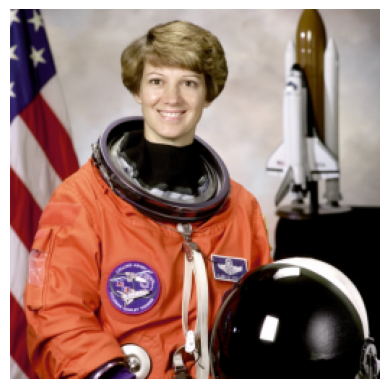

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

img_res = (256, 256) # Image resolution

gt_img = skimage.transform.resize(skimage.data.astronaut(), img_res)
gt = torch.from_numpy(gt_img).float().to(device)

image_cpu = gt.cpu().numpy()
plt.imshow(image_cpu)
plt.axis('off')
plt.show()


Since our image is relatively small, we use the ```NDSignalLoader``` class from Alpine to load the image and coordinates in a single batch for training. ```NDSignalLoader``` is a flexible dataloader that can handle N-dimensional signals, and generate coordinate grids for them, simplifying the data preparation process for training.

The ```NDSignalLoader``` class normalizes to the range [0, 1] by default and also supports other normalization methods.

In [4]:
dataset = NDSignalLoader(gt, (img_res[0], img_res[1]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


---

## Defining the model
Alpine provides a flexible way to define the SIREN architecture. In this example, we will use the ```Siren``` class from Alpine to create our model. 

The INR maps 2D coordinates to RGB values, so the input dimension is 2 (for x and y coordinates) and the output dimension is 3 (for R, G, B channels). We will use a hidden layer size of 256 and 5 hidden layers. The `omega_0` parameter controls the frequency of the sine activation functions, which is crucial for capturing high-frequency details in the image.


In [5]:
model = Siren(
    in_features=2,
    out_features=3,
    hidden_features=256,
    hidden_layers=5,
    outermost_linear=True,
    omegas=[30.0, 30.0, 30.0, 30.0, 30.0],
    bias = True
).to(device)

if device.type == 'cuda':
    ("Compiling model for CUDA backend...")
    model = torch.compile(model)

print(model)

Siren(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Sine()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sine()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Sine()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Sine()
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)



---

## Training the SIREN Model
Now that we have defined the SIREN model, we can train it on the image data. 

We use the `fit_signal` method provided by Alpine to train the model. This method encapsulates the training process by handling the forward and backward passes, updating the model parameters, and tracking metrics. Alpine's custom `fit_signal` function is specifically designed to streamline the training of implicit neural representations, making it easier to focus on model design and evaluation.

To monitor the training progress, we use two metrics:
- **Peak Signal-to-Noise Ratio (PSNR):** Measures the quality of the reconstructed image.
- **Structural Similarity Index Measure (SSIM):** Evaluates the structural similarity between the ground truth and the reconstructed image.

The training process runs for 2000 iterations, and we track the loss history and metrics during training.


In [6]:
metric_trackers = {
    'psnr' : MetricTracker(PeakSignalNoiseRatio(data_range=1.0).to(device)),
    'ssim' : MetricTracker(SSIM(signal_shape=img_res).to(device)),
}

results = model.fit_signal(
    dataloader=dataloader,
    n_iters=2000,
    track_loss_history=True,
    return_features=True,
    metric_trackers=metric_trackers)


Iteration 1999/2000.  Loss (over dataloader): 0.000143: 100%|██████████| 2000/2000 [02:27<00:00, 13.55it/s]


## Evaluating the model
After training the SIREN model, we evaluate its performance using the metrics tracked during training. Specifically, we analyze the Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index Measure (SSIM) to assess the quality of the reconstructed image. Additionally, we visualize the reconstructed image to compare it with the ground truth.

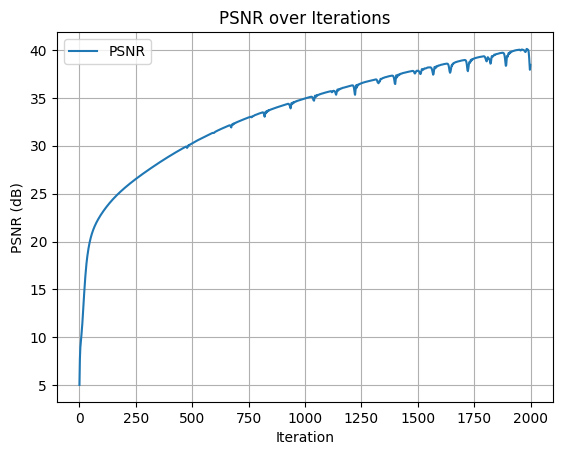

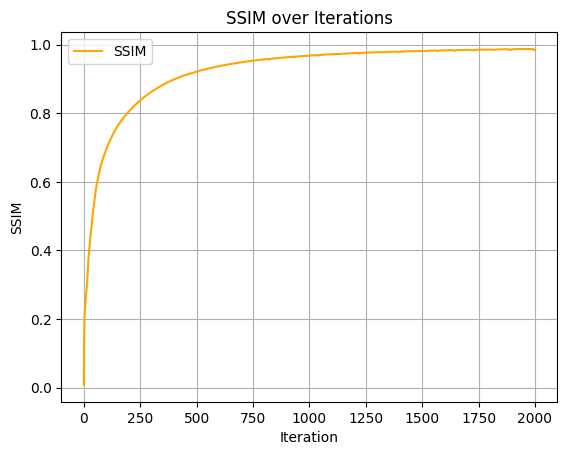

In [7]:
output = results['output']
all_metrics = results['metrics']

# Plot psnr
plt.plot(all_metrics['psnr'], label='PSNR')
plt.xlabel('Iteration')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations')
plt.legend()
plt.grid()
plt.show()

# Plot ssim
plt.plot(all_metrics['ssim'], label='SSIM', color='orange')
plt.xlabel('Iteration')
plt.ylabel('SSIM')
plt.title('SSIM over Iterations')
plt.legend()
plt.grid()
plt.show()

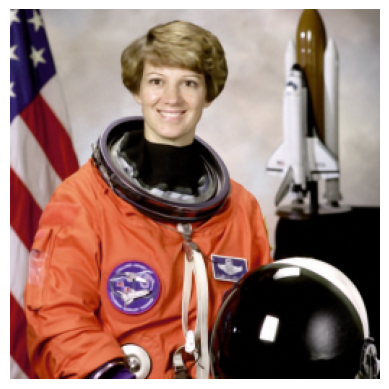

In [9]:

plt.figure()
plt.imshow(output.cpu().detach().numpy().reshape(256,256,3).clip(0,1))
plt.axis('off')
plt.show()